In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Kutuphaneleri yukluyoruz

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [61]:
# Veri setinin yolunu veriyoruz

data_dir = r'/content/drive/My Drive/MitasPOC/datasets'
yes = list(glob.glob(data_dir+"/yes/*"))
no  = list(glob.glob(data_dir+"/no/*"))
len(yes)
 
#PIL.Image.open(str(yes[1]))

1240

In [62]:
# Istedigimiz boyutlari belirliyoruz

batch_size = 32
img_height = 350
img_width = 350

In [64]:
# Verimizi %80 train olacak sekilde ayiriyoruz 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1465 files belonging to 2 classes.
Using 1172 files for training.


In [65]:
# # Verimizi %20 validation olacak sekilde ayiriyoruz 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1465 files belonging to 2 classes.
Using 293 files for validation.


In [66]:
# Alfabetik olarak class isimlerimizi yazdiriyoruz
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


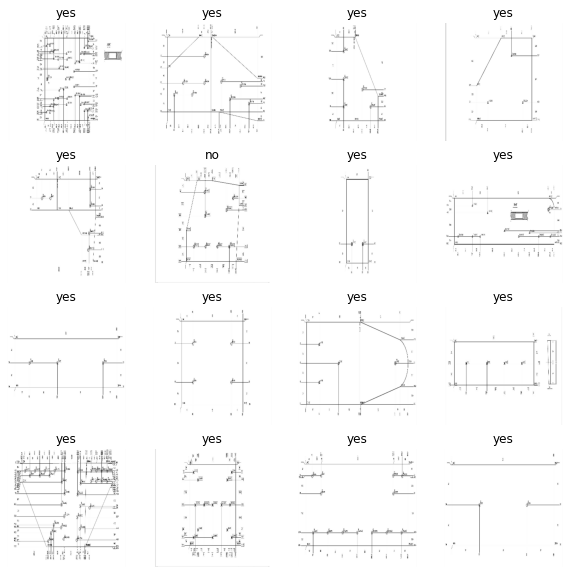

In [72]:
# Veriden rastgele 16 resimi gorsellestiriyoruz

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
# Train verisinin icerisindeki resimlerin bilgilerini bastiriyoruz

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 350, 350, 3)
(32,)


In [69]:
# Veriyi karistirip modele hazir hale getiriyoruz

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [70]:
# Veriyi standart hale getiriyoruz. [0,1] lerden olusacak sekilde olceklendiriyoruz

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [71]:
# Datasetteki verilerin yollarini haritalandiriyoruz
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [73]:
# Yapay sinir agi modelimizi olusturuyoruz

num_classes = 2
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [74]:
# Modeli calisir hale getiriyoruz

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
# Modelin sonucuna bakiyoruz

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 350, 350, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 350, 350, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 175, 175, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 175, 175, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 64)        0

In [76]:
# Egitim sayisini vererek modeli egitiyoruz

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
37/37 [==============================] - 138s 4s/step - loss: 1.1393 - accuracy: 0.8063 - val_loss: 0.3954 - val_accuracy: 0.8635
Epoch 2/10
37/37 [==============================] - 135s 4s/step - loss: 0.4112 - accuracy: 0.8439 - val_loss: 0.3643 - val_accuracy: 0.8635
Epoch 3/10
37/37 [==============================] - 133s 4s/step - loss: 0.2985 - accuracy: 0.8771 - val_loss: 0.3915 - val_accuracy: 0.8498
Epoch 4/10
37/37 [==============================] - 132s 4s/step - loss: 0.2167 - accuracy: 0.9113 - val_loss: 0.3088 - val_accuracy: 0.8737
Epoch 5/10
37/37 [==============================] - 138s 4s/step - loss: 0.1097 - accuracy: 0.9642 - val_loss: 0.3120 - val_accuracy: 0.8976
Epoch 6/10
37/37 [==============================] - 133s 4s/step - loss: 0.0891 - accuracy: 0.9659 - val_loss: 0.4711 - val_accuracy: 0.8840
Epoch 7/10
37/37 [==============================] - 134s 4s/step - loss: 0.0437 - accuracy: 0.9872 - val_loss: 0.4193 - val_accuracy: 0.8874
Epoch 8/10
37

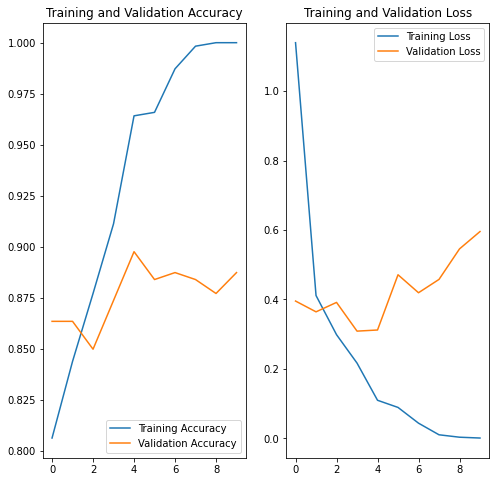

In [80]:
# Egittigimiz modelin Accuracy ve Loss degerlerini gorsellestiriyoruz

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [83]:
# Veriyi zenginlestirmek icin yapay veri ekliyoruz

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

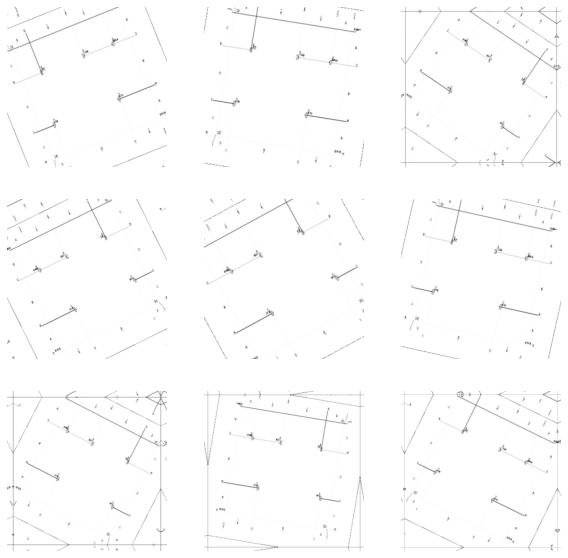

In [84]:
# Yeni olusturdugumuz verileri gorsellestiriyoruz

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [87]:
# Yeni modelimizi kuruyoruz

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [88]:
# Modeli calisir hale getiriyoruz

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
# Modelin sonucuna bakiyoruz

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 350, 350, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 350, 350, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 350, 350, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 175, 175, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 175, 175, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 87, 87, 64)       

In [90]:
# Egitim sayisini vererek modeli egitiyoruz

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
37/37 [==============================] - 166s 4s/step - loss: 1.1176 - accuracy: 0.8234 - val_loss: 0.4156 - val_accuracy: 0.8635
Epoch 2/15
37/37 [==============================] - 161s 4s/step - loss: 0.4410 - accuracy: 0.8422 - val_loss: 0.4081 - val_accuracy: 0.8635
Epoch 3/15
37/37 [==============================] - 165s 4s/step - loss: 0.4444 - accuracy: 0.8422 - val_loss: 0.4069 - val_accuracy: 0.8635
Epoch 4/15
37/37 [==============================] - 159s 4s/step - loss: 0.4577 - accuracy: 0.8422 - val_loss: 0.4020 - val_accuracy: 0.8635
Epoch 5/15
37/37 [==============================] - 164s 4s/step - loss: 0.4310 - accuracy: 0.8422 - val_loss: 0.4075 - val_accuracy: 0.8669
Epoch 6/15
37/37 [==============================] - 159s 4s/step - loss: 0.4276 - accuracy: 0.8404 - val_loss: 0.4306 - val_accuracy: 0.8532
Epoch 7/15
37/37 [==============================] - 165s 4s/step - loss: 0.4341 - accuracy: 0.8422 - val_loss: 0.4366 - val_accuracy: 0.8498
Epoch 8/15
37

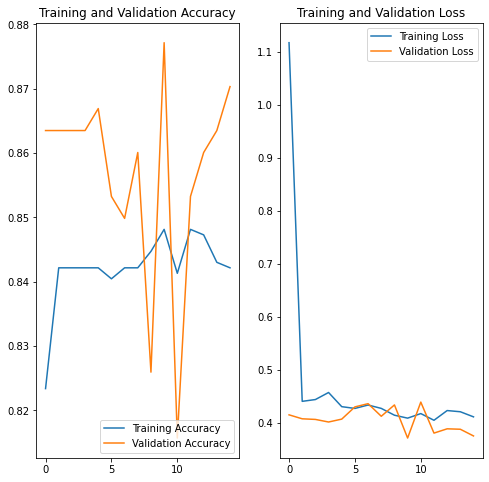

In [92]:
# Egittigimiz modelin Accuracy ve Loss degerlerini gorsellestiriyoruz

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
# Egittigimiz modeli kaydediyoruz

model.save('/content/drive/My Drive/Selam Ben MitasPOC/model.h5')

In [111]:
# Kayit ettigimiz modeli yukluyoruz

new_model = keras.models.load_model('/content/drive/My Drive/Selam Ben MitasPOC/model.h5')

In [112]:
# Ornek bir veri vererek tahminleme yapiyoruz

img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Selam Ben MitasPOC/datasets/no/no0.png', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to no with a 67.55 percent confidence.


In [2]:
jupyter-nbconvert --to PDFviaHTML MitasPrediction.ipynb

SyntaxError: invalid syntax (<ipython-input-2-ad84d548a764>, line 1)